In [574]:
import torch
import torch.nn.functional as F
import torchaudio
from torchaudio import transforms

import matplotlib.pyplot as plt

import librosa
import numpy as np

from pathlib import Path

%cd ../io
from load import readAudio, readAnnotations, compute_log_filterbank, compute_log_filter_spectrogram
%cd ..
from preprocess import invert_mel_spectrogram, invert_log_filter_spectrogram
%cd notebooks

import IPython

/Users/runarfosse/Desktop/OneDrive - University of Bergen/Master Thesis/io
/Users/runarfosse/Desktop/OneDrive - University of Bergen/Master Thesis
/Users/runarfosse/Desktop/OneDrive - University of Bergen/Master Thesis/notebooks


/Users/runarfosse/Library/Python/3.11/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Display some example spectrograms

In [575]:
path = Path("../data/SADTP/Red Swan/mix.wav")

waveform, sr = torchaudio.load(path)
waveform = waveform.mean(dim=0)[sr*215:sr*220]

n_fft, win_length, hop_length, power, f_min, f_max, normalized = 2048, 512, (sr // 100), 1, 20, 20000, True
spectrogram = torchaudio.transforms.Spectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length, power=power)(waveform)
mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=n_fft, win_length=win_length, hop_length=hop_length, power=power, n_mels=84, normalized=normalized, f_min=f_min, f_max=f_max)(waveform)
log_filter_spectrogram = compute_log_filter_spectrogram(waveform, sr=sr, n_fft=n_fft, win_length=win_length, power=power, norm=normalized, f_min=f_min, f_max=f_max)

log_spectrogram = torch.log10(spectrogram + 1)
log_mel_spectrogram = torch.log10(mel_spectrogram + 1)

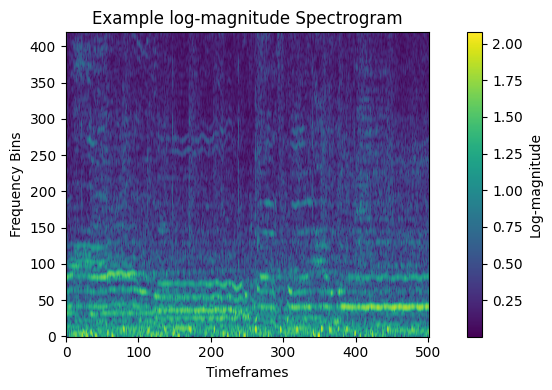

In [576]:
fig, ax = plt.subplots(figsize=(8, 4))
image = ax.imshow(log_spectrogram[:420])
plt.colorbar(image, label="Log-magnitude")
ax.invert_yaxis()

plt.title("Example log-magnitude Spectrogram")
ax.set_ylabel("Frequency Bins")
ax.set_xlabel("Timeframes")

fig.tight_layout()
plt.savefig("../thesis/figures/logspectrogram.png", bbox_inches='tight')
plt.show()

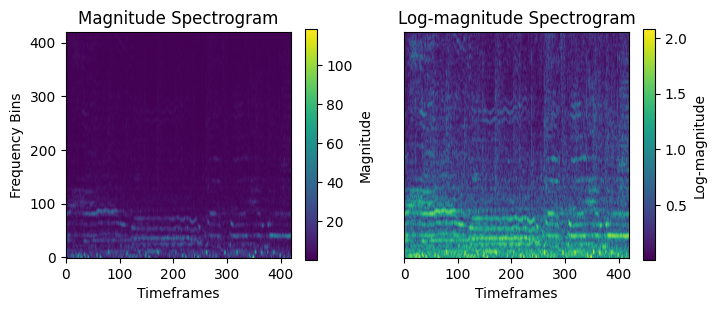

In [577]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
left, right = axes[0].imshow(spectrogram[:420, :420]), axes[1].imshow(log_spectrogram[:420, :420])
plt.colorbar(left, label="Magnitude")
plt.colorbar(right, label="Log-magnitude")
axes[0].invert_yaxis()
axes[1].invert_yaxis()

axes[0].set_ylabel("Frequency Bins")
axes[0].set_xlabel("Timeframes")
axes[0].set_title("Magnitude Spectrogram")
axes[1].get_yaxis().set_visible(False)
axes[1].set_xlabel("Timeframes")
axes[1].set_title("Log-magnitude Spectrogram")

#plt.suptitle('Comparison of magnitude and log-magnitude Spectrogram')
#fig.tight_layout()
plt.savefig("../thesis/figures/spectrogramlogspectrogram.png", bbox_inches='tight')
plt.show()

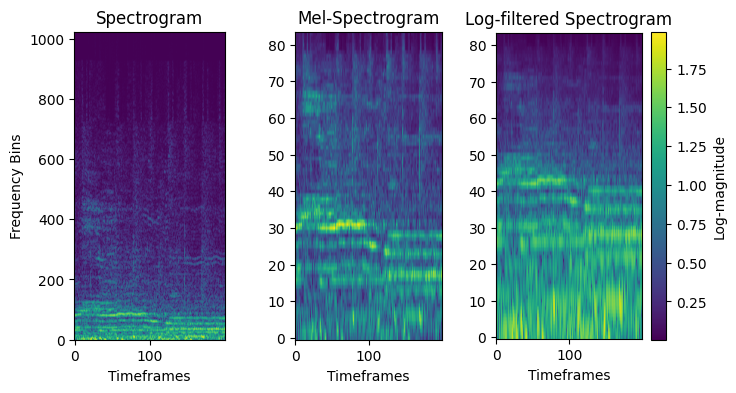

In [578]:
fig, axes = plt.subplots(ncols=3, figsize=(8, 4))
left, middle, right = axes[0].imshow(log_spectrogram[:, :200], aspect=0.4), axes[1].imshow(log_mel_spectrogram[:, :200], aspect=5.0), axes[2].imshow(log_filter_spectrogram[:, :200], aspect=5.0)
plt.colorbar(right, label="Log-magnitude")
axes[0].invert_yaxis()
axes[1].invert_yaxis()
axes[2].invert_yaxis()

axes[0].set_ylabel("Frequency Bins")
axes[0].set_xlabel("Timeframes")
axes[0].set_title("Spectrogram")
#xes[1].get_yaxis().set_visible(False)
axes[1].set_xlabel("Timeframes")
axes[1].set_title("Mel-Spectrogram")
#axes[2].get_yaxis().set_visible(False)
axes[2].set_xlabel("Timeframes")
axes[2].set_title("Log-filtered Spectrogram")

#plt.suptitle('Comparison of Spectrogram, Mel Spectrogram and Log-filter Spectrogram')
#fig.tight_layout()
plt.savefig("../thesis/figures/allspectrograms.png", bbox_inches='tight')
plt.show()

# Display an example of the Fourier Transform

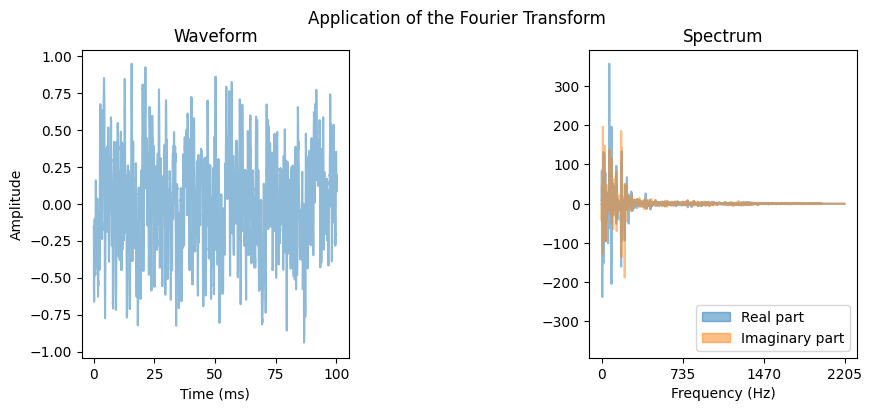

In [579]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

# Display waveform on the left
signal = waveform[:sr // 10].numpy()
librosa.display.waveshow(signal, sr=sr // 1000, alpha=0.5, ax=axes[0], axis=None)

axes[0].set_title("Waveform")
axes[0].set_ylabel("Amplitude")
axes[0].set_xlabel("Time (ms)")
axes[0].set_xticks([0, 25, 50, 75, 100])

# And Fourier Transform on the right
transform = np.fft.fft(signal)[:sr // 20]
librosa.display.waveshow(np.real(transform), sr=1, alpha=0.5, ax=axes[1], label="Real part", axis=None)
librosa.display.waveshow(np.imag(transform), sr=1, alpha=0.5, ax=axes[1], label="Imaginary part", axis=None)

axes[1].set_title("Spectrum")
#axes[1].set_ylabel("Amplitude")
axes[1].set_xlabel("Frequency (Hz)")
axes[1].legend(loc="lower right")
axes[1].set_xticks([0, transform.shape[0]//3, 2*transform.shape[0]//3, transform.shape[0]])

fig.subplots_adjust(wspace=0.9)
plt.suptitle("Application of the Fourier Transform")
#fig.tight_layout()
plt.savefig("../thesis/figures/fouriertransform.png", bbox_inches='tight')
plt.show()

# And an example of the Short-Time Fourier Transform

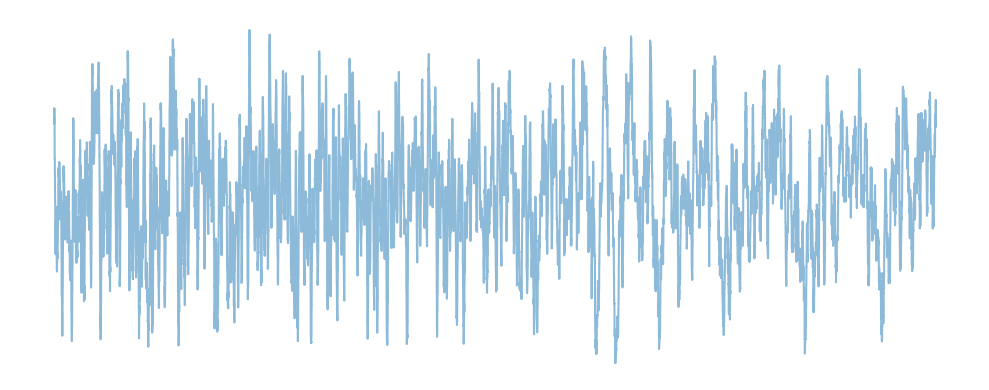

In [580]:
fig, ax = plt.subplots(figsize=(10, 4))

# Display waveform of the signal
signal = waveform[sr:sr + sr // 5].numpy()
librosa.display.waveshow(signal, sr=sr // 1000, alpha=0.5, ax=ax, axis=None)

# Remove plot decor
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

#plt.suptitle("Application of the Short-Time Fourier Transform")
fig.tight_layout()
plt.savefig("../thesis/figures/stftfull.png", bbox_inches='tight')
plt.show()

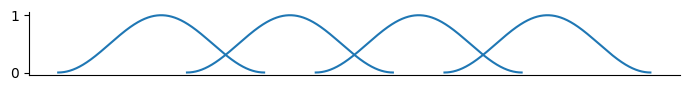

In [581]:
fig, ax = plt.subplots(figsize=(7, 1))

# Display all Hann windows
window_length, hop_length = 2048, 5/8
window = torch.hann_window(window_length=window_length)
for i in range(4):
    ax.plot(torch.arange(i * hop_length , 1 + i * hop_length, 1 / window_length), window, color="tab:blue")

# Remove plot decor
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
#ax.get_yaxis().set_ticks([])

fig.tight_layout()
plt.savefig("../thesis/figures/stftwindows.png", bbox_inches='tight')
plt.show()

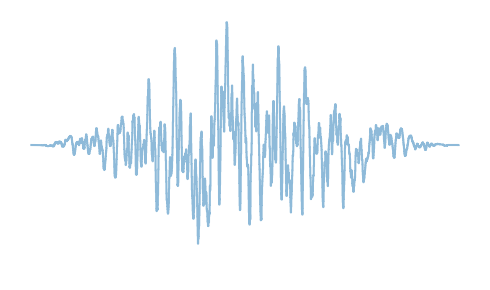

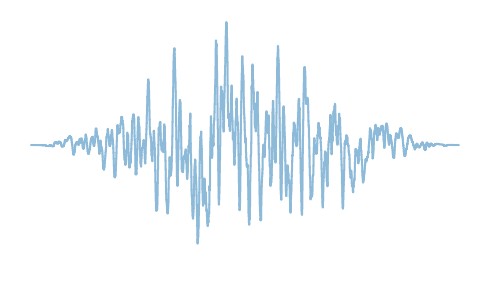

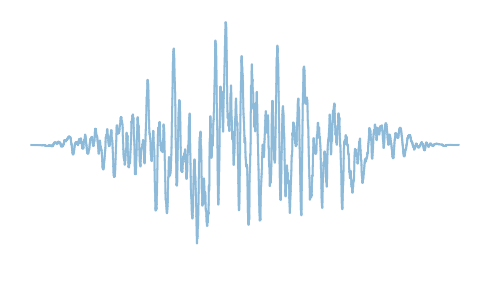

In [582]:
for i in range(3):
    fig, ax = plt.subplots(figsize=(5, 3))

    # Display waveform of the partitioned signal
    start = int(hop_length * 4 * i)
    signal = (waveform[start : start + window_length] * window).numpy()
    librosa.display.waveshow(signal, sr=sr // 1000, alpha=0.5, ax=ax, axis=None)

    # Remove plot decor
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

    fig.tight_layout()
    plt.savefig(f"../thesis/figures/stftwindow{i}.png", bbox_inches='tight', transparent=True)
    plt.show()

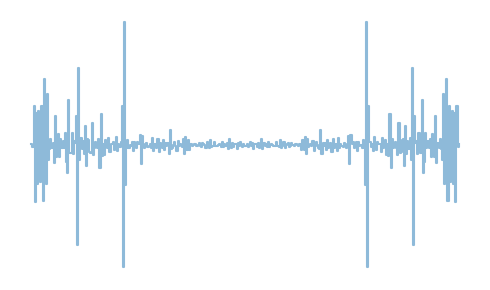

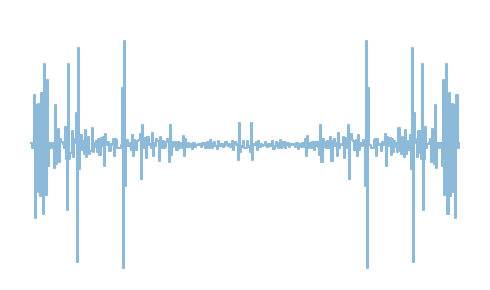

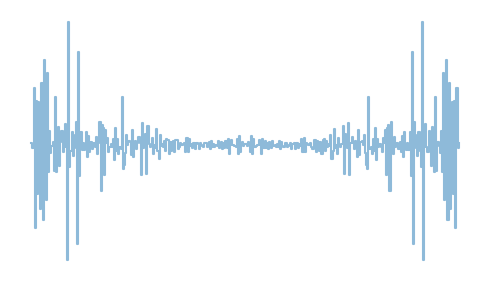

In [583]:
for i in range(3):
    fig, ax = plt.subplots(figsize=(5, 3))

    # Display STFT of the partitioned signal
    start = int(hop_length * 4 * i)
    signal = (waveform[start : start + window_length] * window).numpy()
    transform = np.fft.fft(signal)[:192]
    mirrored = np.concatenate((transform, transform[::-1]))
    librosa.display.waveshow(np.real(mirrored), sr=1, alpha=0.5, ax=ax, label="Real part", axis=None)
    #librosa.display.waveshow(np.imag(mirrored), sr=1, alpha=0.5, ax=ax, label="Imaginary part", axis=None)

    # Remove plot decor
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

    fig.tight_layout()
    plt.savefig(f"../thesis/figures/stft{i}.png", bbox_inches='tight')
    plt.show()

# Display an example of the Hann window

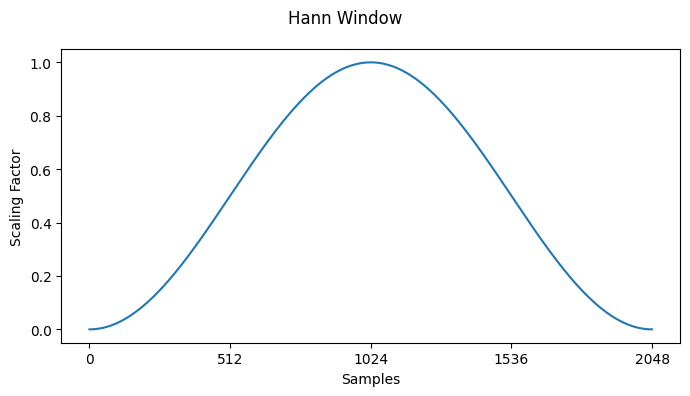

In [589]:
fig, ax = plt.subplots(figsize=(7, 4))

# Display waveform of the signal
window_length = 2048
hann_window = torch.hann_window(window_length=window_length);
ax.plot(torch.arange(0, window_length), hann_window)

ax.set_ylabel("Scaling Factor")
ax.set_xlabel("Samples")
ax.set_xticks(torch.arange(0, window_length+1, window_length // 4))

plt.suptitle("Hann Window")
fig.tight_layout()
plt.savefig("../thesis/figures/hann.png", bbox_inches='tight')
plt.show()